In [4]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import gp_grid
from gp_grid.misc import rastrigin, elastic_membrane, grid2mat
from pdb import set_trace

# Elastic Membrane Video Reconstruction

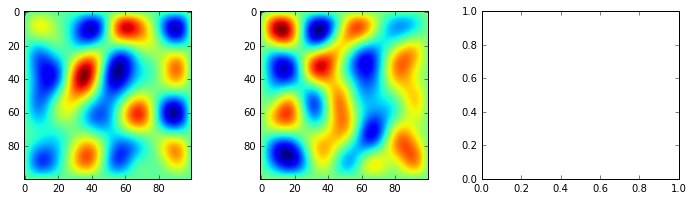

In [32]:
np.random.seed(0)
n = (100, 100, 2) # grid dimensions
n_p, n_q = 8, 8 # number of vertical/horizontal waves
# get random coefficients (corresponding to random initial conditions)
F = np.random.normal(size=(n_p,1))
H = np.random.normal(size=(n_q,1))
C = np.random.normal(size=(n_p,n_q))
D = np.random.normal(size=(n_p,n_q))
# get the grid
xg=[np.linspace(0,1,num=ni).reshape(-1,1) for ni in n[:2]] + [np.linspace(0,1,num=n[2]).reshape(-1,1),]
x = grid2mat(*xg) # convert from grid to actual points
# get the membrane displacement
z = elastic_membrane(x=x[:,(0,)], y=x[:,(1,)], t=x[:,(2,)],
                     F=F, H=H, C=C, D=D, lx=1, ly=1, v=1).reshape(n)
fig, ax = plt.subplots(ncols=3, figsize=(12,3))
ax[0].imshow(z[:,:,0])
ax[1].imshow(z[:,:,-1])


# do several screenshots of the elastic membrane


# Multi-Output Problems
This section will consider datasets with several responses.
This appears in many applications, for example in sensor network applications or engineering design datasets.
In these applications, missing observations are frequently observed.
For example, each output channel may be the result of a complex engineering simulations for a design dataset, and that simulation may fail for some channels.

For simplicity, we will consider a univariate problem (with $d=1$, a single input dimension).

In [ ]:
# see test_direct_covariance script

# Identifying Structure by Grouping Dimensions
Here we will discuss identifying non-obvious structure in a dataset by grouping dimensions together to form a grid.
We will consider a spatial-temporal climate dataset (as was studied in (Evans and Nair, 2018) where the latitude/longditude locations of the weather stations *do not* form a grid.
We can generate a dataset like this as follows

Trefor W. Evans and Prasanth B. Nair, *Exploiting Structure for Fast Kernel Learning*. In SIAM International Conference on Data Mining, 2018.

In [ ]:
# generate the dataset
np.random.seed(0)
spatial = np.random.rand(10,2) # (latitude, longditude) coordinates of each weather station
temporal = np.linspace(0,2.*np.pi, num=30).reshape((-1,1))
x = grid2mat(spatial, temporal)


# Use the membrane dataset